# Imports

In [56]:
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

camels_spat_dir = Path('/gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_spat_NH')
shapes_dir = camels_spat_dir / 'merged_lumped_shapes'

# Load Data

In [57]:
# Load the results
result_df = pd.read_csv('test_cyril_seed111.csv')

# Ensure negative NSE values are set to zero
result_df['NSE'] = result_df['NSE'].apply(lambda x: max(x, 0))

# List of basins
basins = result_df['basin'].unique()

# Loading and reprojecting basins and states

In [58]:
## Read the basin shapefile
gdf_basins = gpd.read_file(shapes_dir / 'merged_lumped_outlines.shp')
# Subset the basins to only include the ones that are usable
gdf_basins = gdf_basins[gdf_basins['Station_id'].isin(basins)]

gdf_borders = gpd.read_file(camels_spat_dir / 'NA_PoliticalDivision' / 'boundaries_p_2021_v3.shp')
states = gpd.read_file(shapes_dir / 'USA_Canada_ShapefileMerge.shp')

gdf_basins.value_counts('Country')

Country
USA    474
CAN    454
Name: count, dtype: int64

In [59]:
# # Set the CRS for gdf_basins
# gdf_basins.crs = from_epsg(4326)

# # Set a common CRS for both GeoDataFrames
# common_crs = 'ESRI:102008'
# gdf_basins = gdf_basins.to_crs(common_crs)

# # Compute the centroids of the basins
# gdf_basins['centroid'] = gdf_basins.centroid

# gdf_borders = gdf_borders.to_crs(common_crs)
# gdf_borders = gdf_borders.set_crs(common_crs, allow_override=True)

In [ ]:
# Ensure the CRS for gdf_basins
gdf_basins.crs = 'EPSG:4326'

# Set a common CRS for both GeoDataFrames
common_crs = 'ESRI:102008'
gdf_basins = gdf_basins.to_crs(common_crs)

# Compute the centroids of the basins after reprojection
gdf_basins['centroid'] = gdf_basins.geometry.centroid

# Ensure gdf_borders is in the same CRS
gdf_borders = gdf_borders.to_crs(common_crs)

In [60]:
# Merge the basin geometries with NSE values
gdf_basins = gdf_basins.merge(result_df[['basin', 'NSE']], left_on='Station_id', right_on='basin', how='left')

# Plot results

KeyError: 'centroid'

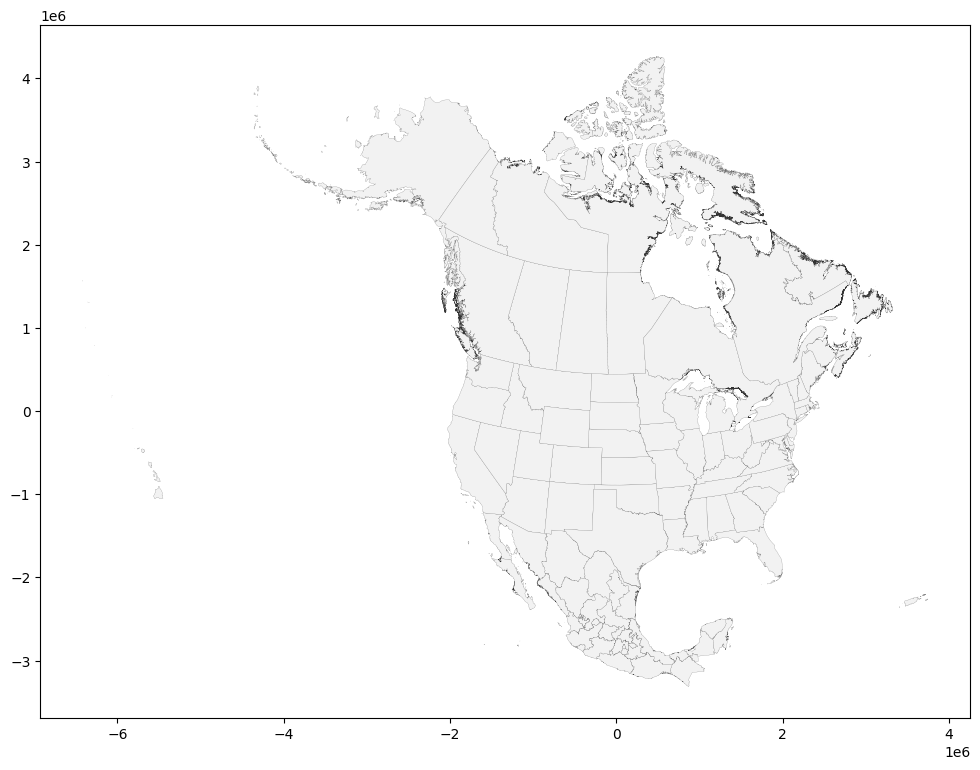

In [61]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the reprojected gdf_borders
gdf_borders.plot(ax=ax, facecolor='0.95', edgecolor='0.2', linewidth=0.1)

# Define the colormap based on the metric values
cmap = plt.cm.gnuplot
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)  # Adjust vmax to 1.0

# Plot each basin using centroids
gdf_basins.apply(lambda row: ax.plot(row['centroid'].x, row['centroid'].y, 'o',
                                     markersize=5, color=cmap(norm(row['NSE']))), axis=1)

# Create an axis for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)

# Add a title
nse_less_than_0 = result_df['NSE'][result_df['NSE'] <= 0].count()
ax.set_title(f"NSE results ({len(result_df)} basins | NSE $\leq 0$: {nse_less_than_0} counts)")

# Add a histogram plot to the right of the colorbar
hist_ax = divider.append_axes("right", size="10%", pad=0.6)  # adjust pad as needed

hist_values = gdf_basins['NSE'].values
n_bins = 20
bins = np.linspace(hist_values.min(), hist_values.max(), n_bins + 1)

hist_ax.hist(hist_values, bins=bins, orientation='horizontal', color='tab:blue', alpha=0.5)
hist_ax.set_yticks([])  # remove y-ticks
hist_ax.set_ylim(hist_values.min(), hist_values.max())  # set y-axis limits to match the data range

# Adjust the x-ticks
xticks = hist_ax.get_xticks()
hist_ax.set_xticks(xticks[::3])  # set the x-ticks to every 3rd value
hist_ax.set_xlim(0, hist_ax.get_xlim()[1])  # set the right limit to the maximum value

# Move the x label to the top and adjust ticks
hist_ax.set_xlabel('')
hist_ax.xaxis.set_label_position('top')
hist_ax.set_xlabel('Frequency', labelpad=10)
hist_ax.xaxis.tick_top()
hist_ax.tick_params(axis='x', which='both', labeltop=True, labelbottom=False)

# Get rid of box lines
hist_ax.spines['top'].set_visible(False)
hist_ax.spines['right'].set_visible(False)
hist_ax.spines['bottom'].set_visible(False)
hist_ax.spines['left'].set_visible(False)

# Calculate the gap height based on the current ylim
gap = 0.04  # Gap between the line and the text label - histogram
ylim = hist_ax.get_ylim()
gap_height = gap * (ylim[1] - ylim[0])

# Add mean and median value plots to the histogram
mean_value = np.mean(hist_values)
median_value = np.median(hist_values)
max_value = max(mean_value, median_value)  # Find the greatest value

# Plot mean value
if mean_value < max_value:
    hist_ax.axhline(mean_value, color='tab:red', linestyle='--', linewidth=2)
    hist_ax.text(hist_ax.get_xlim()[1], mean_value - gap_height, f'Mean: {mean_value:.3f}', va='bottom', ha='right', color='tab:red')
else:
    hist_ax.axhline(mean_value, color='tab:red', linestyle='--', linewidth=2)
    hist_ax.text(hist_ax.get_xlim()[1], mean_value + gap_height, f'Mean: {mean_value:.3f}', va='top', ha='right', color='tab:red')

# Plot median value
if median_value < max_value:
    hist_ax.axhline(median_value, color='green', linestyle='--', linewidth=2)
    hist_ax.text(hist_ax.get_xlim()[1], median_value - gap_height, f'Median: {median_value:.3f}', va='bottom', ha='right', color='green')
else:
    hist_ax.axhline(median_value, color='green', linestyle='--', linewidth=2)
    hist_ax.text(hist_ax.get_xlim()[1], median_value + gap_height, f'Median: {median_value:.3f}', va='top', ha='right', color='green')

# Set chart junk
ax.set_xlim([-2.5*1e6, 3.1*1e6])
ax.set_ylim([-1.6*1e6, 3.7*1e6])
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Show the plot
plt.show()